# Ipynb test

In [1]:
#!/usr/bin/env python
# coding: utf-8

#!/usr/bin/env python
# coding: utf-8

import time
import math
import sys
import os
import pickle

import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

from pylab import *
from matplotlib import cm
from matplotlib import style
from matplotlib.ticker import LinearLocator

from potentials import transutils as utils
#from potentials import orbital as pot
from potentials.supergravity import setup_supergravity
#from potentials.orbital import setup_orbital

from tqdm.contrib.telegram import tqdm, trange




Mp = 1

# plt.style.use('classic')
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    }
)
plt.rcParams.update({"axes.labelsize": 15, "axes.titlesize": 25, "legend.fontsize": 10})



def run_bispectrum(bispec):
    print("start bispectrum")
    bispec()
    bispec.plot_fnl(save=True, show=False)
    bispec.plot_bispectrum(save=True, show=False)
    bispec.plot_three_pt_correlations(save=True, show=False)
    return bispec


def run_powerspectrum(twopt):
    print("start spectrum")
    twopt()
    twopt.plot_sigma_evolution(save=True, show=False)
    twopt.plot_zeta_evolution(save=True, show=False)
    #pz, k_out = twopt.p_spectra(pool=True)
    #twopt.plot_p_spectra(pz, k_out, save=True, show=False)

    twopt.spectral_index()
    print(twopt.n_s, twopt.r)
    return twopt


ModuleNotFoundError: No module named 'gravipy'

## orbital

In [ ]:
# EGNO
alpha = 1
M = 1e-3
c = 1e3
a = 0.5


def evolution(N_start, N_end, n_steps, R0=1, A0=100, V0=1):
    fields = np.array([R0, A0], dtype=np.float64)
    p = np.array([V0, R0, 0, 0], dtype=np.float64)
    print(f"python3 orbital_tr_analyser.py orbital -i {N_start} -f {N_end} -steps {n_steps} -R {R0} -V {V0} -A {A0}")
    os.system(f"python3 orbital_tr_analyser.py orbital -i {N_start} -f {N_end} -steps {n_steps} -R {R0} -V {V0} -A {A0}")

    with open(f"./data/orbital.obj", "rb") as file:
        orb = pickle.load(file)
    return orb
    '''
        
    print('start run')    
    fields = np.array([R0, A0]) #2.4*np.pi
    p = np.array([V0, R0, 0, 0])

    fsym = sym.symarray("f", len(fields))
    psym = sym.symarray("p", len(p))
    dHdf = sym.lambdify([fsym, psym], pot.eff_V(fsym, psym).diff(fsym[1]))

    orb = pot.BackgroundEvolution(fields, p)
    orb.initial = np.concatenate(
        (fields, [0.0, -2.0 * dHdf(fields, p) / pot.func(fields, p)])
    )

    return orb(N_start=N_start, N_end=N_end, n_steps=n_steps, slow_roll=True)
    '''


def fit_trajectory(sfield, N_start, N_end, steps, A0=100):
    R0 = float(
        sfield.value[sfield.efolds==N_end,0]
        + sfield.value[sfield.efolds==N_start,0]
    )/2
    print('R0',R0)
    orb = evolution(N_start, N_end, steps, R0, A0=A0)
    return orb

## patching

In [12]:
def patching(sfield, patch_init=6, treshold=3e-5):
    patches = [sfield.efolds[sfield.efolds>=patch_init][0]]
    turningrate = sfield.radius_of_curvature
    reference = turningrate[sfield.efolds>=patches[-1]][0]
    sel = (sfield.efolds>=patches[-1])&(sfield.slow_roll<1)
    patch_ref = np.zeros(turningrate.shape)
    
    average = np.mean(turningrate[sel])
    for i, rate in enumerate(turningrate[sel]):
        if abs(rate - reference)/average > treshold:
            patches.append(sfield.efolds[sel][i])
            reference = rate

        patch_ref[len(patch_ref[sfield.efolds<=patches[0]])+i] += float(len(patches))
    patches.append(sfield.efolds[sel][-1])
    return patches, patch_ref

[6.00075009376172, 42.17027128391049, 49.97874734341793, 52.866608326040755, 54.37429678709839, 55.03437929741218]
R0 0.482837745468486
python3 orbital_tr_analyser.py orbital -i 6.00075009376172 -f 42.17027128391049 -steps 4822 -R 0.482837745468486 -V 1 -A 100
4822
test1
test2
efolds [ 6.00075009  6.00825259  6.01575508 ... 42.1552663  42.16276879
 42.17027128]
R0 0.4781409377497081
python3 orbital_tr_analyser.py orbital -i 42.17027128391049 -f 49.97874734341793 -steps 1041 -R 0.4781409377497081 -V 1 -A 96.84738694180099
R0 0.4744013528334352
python3 orbital_tr_analyser.py orbital -i 49.97874734341793 -f 52.866608326040755 -steps 385 -R 0.4744013528334352 -V 1 -A 96.13946283825655
R0 0.4711326122565076
python3 orbital_tr_analyser.py orbital -i 52.866608326040755 -f 54.37429678709839 -steps 201 -R 0.4711326122565076 -V 1 -A 95.87215177263201
R0 0.4689647144752649
python3 orbital_tr_analyser.py orbital -i 54.37429678709839 -f 55.03437929741218 -steps 89 -R 0.4689647144752649 -V 1 -A 95.7

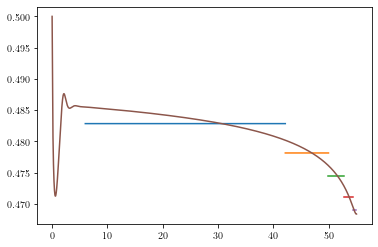

In [13]:
s = open('./data/supergravity.obj', 'rb')
sugra = pickle.load(s)
sfield = sugra.fields
patches, patch_ref = patching(sfield, treshold=1e-1)
print(patches)

orb_fields = list()
back=None

#for i in tqdm(
#    range(1,len(patches)),
#    token="5059373047:AAGENHYbfy6GWJzcr8rtKA19CgNDsMFUlHQ",
#    chat_id="-1001650413269"
#):
for i in range(1,len(patches)):
    if i==1:
        A0 = 100
        #A0 = float(sfield.value[sfield.efolds==patches[0],1])
    else:
        A0 = orb_fields[-1].value[-1,1]
        
    cosmo = fit_trajectory(
        sfield,
        float(patches[i-1]),
        float(patches[i]),
        int(np.shape(np.where(patch_ref==i)[0])[0]),
        A0
    )
    if back is None:
        back = cosmo
    else:
        back = back + cosmo

    fields = cosmo.fields
    
    plt.plot(fields.efolds,fields.value[:,0])
    orb_fields.append(fields)
plt.plot(sfield.efolds, sfield.value[:,0])
plt.show()






In [23]:
plt.plot(sfield.efolds, sfield.entropy_mass)
#plt.plot(sfield.efolds, sfield.slow_roll)
plt.show()

fsym = sym.symarray('f',2)
psym = sym.symarray('p',4)
print(back.G_sympy(fsym,psym))
print(sfield.G_sympy(fsym,psym))
print()
print(back.V_sympy(fsym,psym))
print(sfield.V_sympy(fsym,psym))


( 0 0 0 0 )
( 0 0 0 1 )
( 0 0 1 0 )
( 0 0 1 1 )
( 0 1 0 0 )
( 0 1 0 1 )
( 0 1 1 0 )
( 0 1 1 1 )
( 1 0 0 0 )
( 1 0 0 1 )
( 1 0 1 0 )
( 1 0 1 1 )
( 1 1 0 0 )
( 1 1 0 1 )
( 1 1 1 0 )
( 1 1 1 1 )
( 2 0 0 0 )
( 2 0 0 1 )
( 2 0 1 0 )
( 2 0 1 1 )
( 2 1 0 0 )
( 2 1 0 1 )
( 2 1 1 0 )
( 2 1 1 1 )
( 3 0 0 0 )
( 3 0 0 1 )
( 3 0 1 0 )
( 3 0 1 1 )
( 3 1 0 0 )
( 3 1 0 1 )
( 3 1 1 0 )
( 3 1 1 1 )
( 4 0 0 0 )
( 4 0 0 1 )
( 4 0 1 0 )
( 4 0 1 1 )
( 4 1 0 0 )
( 4 1 0 1 )
( 4 1 1 0 )
( 4 1 1 1 )
( 5 0 0 0 )
( 5 0 0 1 )
( 5 0 1 0 )
( 5 0 1 1 )
( 5 1 0 0 )
( 5 1 0 1 )
( 5 1 1 0 )
( 5 1 1 1 )
( 6 0 0 0 )
( 6 0 0 1 )
( 6 0 1 0 )
( 6 0 1 1 )
( 6 1 0 0 )
( 6 1 0 1 )
( 6 1 1 0 )
( 6 1 1 1 )
( 7 0 0 0 )
( 7 0 0 1 )
( 7 0 1 0 )
( 7 0 1 1 )
( 7 1 0 0 )
( 7 1 0 1 )
( 7 1 1 0 )
( 7 1 1 1 )
( 8 0 0 0 )
( 8 0 0 1 )
( 8 0 1 0 )
( 8 0 1 1 )
( 8 1 0 0 )
( 8 1 0 1 )
( 8 1 1 0 )
( 8 1 1 1 )
( 9 0 0 0 )
( 9 0 0 1 )
( 9 0 1 0 )
( 9 0 1 1 )
( 9 1 0 0 )
( 9 1 0 1 )
( 9 1 1 0 )
( 9 1 1 1 )
( 10 0 0 0 )
( 10 0 0 1 )
( 10 0 1 0 )
(

KeyboardInterrupt: 

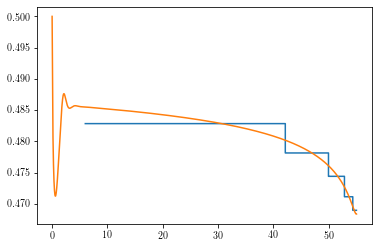

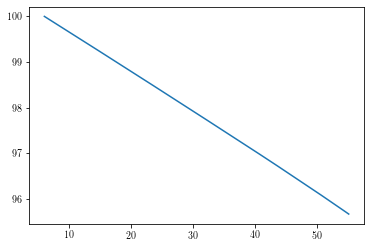

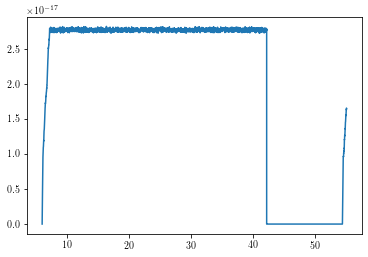

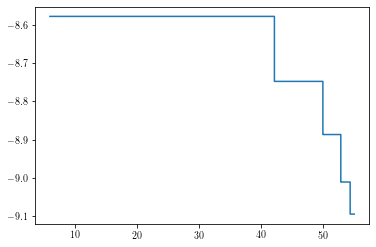

In [15]:
plt.plot(back.fields.efolds, back.fields.value[:,0])
plt.plot(sfield.efolds, sfield.value[:,0])
plt.show()
plt.plot(back.fields.efolds, back.fields.value[:,1])
plt.show()

plt.plot(back.fields.efolds, back.fields.dot[:,0])
plt.show()
plt.plot(back.fields.efolds, back.fields.dot[:,1])
plt.show()

[0.48283775 0.48283775 0.48283775 ... 0.46896471 0.46896471 0.46896471]
[ 6.00075009  6.00825259  6.01575508 ... 55.01937742 55.02687836
 55.0343793 ]


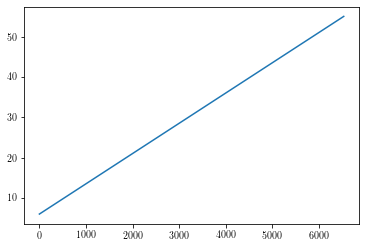

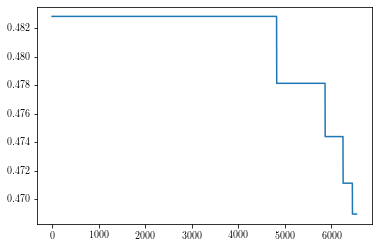

In [16]:
print(back.fields.value[:,0])
print(back.fields.efolds)
plt.plot(back.fields.efolds)
plt.show()

plt.plot(back.fields.value[:,0])
plt.show()

In [ ]:
back.set_exit_mode(15)
twopt = pot.PowerSpectrum(back, NB=4, N_exit=10)

In [ ]:
plt.plot(sfield.efolds,sfield.radius_of_curvature)
plt.xlim(6,55)
plt.ylim(0,1)
plt.show()

In [ ]:
s.close()

In [ ]:
f = sym.symarray('f',2)
p = sym.symarray('p',4)

pot.V_sympy(f,p)